# I. IMPORTS

In [1]:
# All relevant imports for this file are done here. 
# Run the following in terminal if errors are obtained: set DJANGO_SETTINGS_MODULE=ms2ldaviz.settings
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
basedir = 'C:\\Users\\rpetr\\OneDrive\\Desktop\\DISS_CODE\\ms2ldaviz\\ms2ldaviz'
sys.path.append(basedir)
import django
import json
django.setup()
from basicviz.models import Experiment, Alpha, Mass2MotifInstance, FeatureInstance, Feature, Document, Mass2Motif, DocumentMass2Motif, FeatureMass2MotifInstance
import numpy as np
import pylab as plt
import csv
from scipy.special import polygamma as pg
from scipy.special import psi as psi
import time

MEDIA_ROOT is C:\Users\rpetr\OneDrive\Desktop\DISS_CODE\ms2ldaviz\ms2ldaviz\media


# II. COMMON VARIABLES

In [2]:
# Choose experiment ID manually from database. Small number is used for normalisation and e-step below. 
experiment_id=190 
experiment = Experiment.objects.get(id=experiment_id)
SMALL_NUMBER = 1e-100
TIME=[]

# III. CORPUS SETUP

In [3]:
# Get all words/features in the database relevant for the experiment. 
time
features = Feature.objects.filter(experiment_id=experiment)
experiment_words = []
for f in features:
     if f.id not in experiment_words: 
        experiment_words.append(f.id)

In [4]:
# Match each word to an index. 
unique_words = {}
index = 0
for word in experiment_words:
    if word not in unique_words.keys():
        unique_words.update({word:index})
        index+=1

In [5]:
# This prototype uses a single document. The value is known beforehand. Manual input here. 
# BELOW COMMENTS FOR REFERENCE:
# 269485	eawag_0503.ms
# 270314	washington_0978.ms
# 270414	eawag_0758.ms
# 271247	eawag_0759.ms
# 269323 	eawag_0730.ms
experiment_docs=[270414]

In [6]:
# Map each document to a specific ID. 
unique_docs = {}
index = 0 
for doc in experiment_docs: 
    unique_docs.update({doc:index})
    index+=1

In [7]:
# Get words/features for all documents chosen. The output columns are doc_id, word_id and intensity.
feature_instances = FeatureInstance.objects.filter(document_id__in=unique_docs.keys(), feature_id__in=unique_words.keys())
doc_word_data = []
for f in feature_instances:
    doc_word_data.append([unique_docs[int(f.document_id)], unique_words[int(f.feature_id)], f.intensity])

In [8]:
# Create the corpus in {doc_id:{word_id:word_count}} form.
# Inner dictionary is created first {word:word_count} and then added to doc dictionary key.
temp_dict1 = {}
temp_dict2 = {}
for line in doc_word_data: 
    doc = line[0]
    word = line[1]
    count = line[2]
    temp_dict1.update({word:count})
    if doc not in temp_dict2.keys():
        temp_dict2.update({doc:temp_dict1})
corpus_dict = temp_dict2

In [9]:
# Get topics for the experiment. Map them to indices. 
mi = Mass2Motif.objects.filter(experiment=experiment)
unique_topics = {}
index = 0
for m in mi: 
    unique_topics.update({m.id:index})
    index+=1

# IV. GET ALPHA

In [10]:
# Get Alphas from database. Transform them to topic_count length vector.
al = Alpha.objects.filter(mass2motif__experiment=experiment).order_by('mass2motif')
alphas = {}
for a in al:
    alphas.update({unique_topics[a.mass2motif_id]: a.value})
n_motif = len(alphas)
alpha_vec = np.zeros(n_motif)
for pos,val in alphas.items():
    alpha_vec[pos] = val

In [11]:
# Rename for ease. 
alpha_vector = alpha_vec

# V. GET BETA

In [12]:
# Get the Beta values from the database in list form -> topic, word, probability.
beta_pre_pivot = []
mi = Mass2MotifInstance.objects.filter(mass2motif__experiment=experiment)
for m in mi:
    beta_pre_pivot.append([unique_topics[m.mass2motif_id], unique_words[m.feature_id], m.probability]) 

In [13]:
# Create the Beta matrix.
output_arr_beta = np.array(beta_pre_pivot)
K = len(unique_topics)
W = len(unique_words)
pivot_table = np.zeros((K, W)).astype('float')
i = 0
max = len(beta_pre_pivot)
while i<max:
    pivot_table[int(output_arr_beta[i][0]),int(output_arr_beta[i][1])]=output_arr_beta[i][2]
    i+=1

In [14]:
# Normalise the beta matrix. Beta is now ready to be used in the E-step.
pivot_table_normalised = pivot_table
i = 0
while i<K: 
    row = pivot_table_normalised[i, :]
    adjusted_row = row + SMALL_NUMBER
    normalised_row = adjusted_row / np.sum(adjusted_row)
    np.sum(normalised_row)
    pivot_table_normalised[i, :] = normalised_row
    i+=1

# VI. GET ORIGINAL GAMMA(IN NORMALISED FORM THETA)

In [15]:
# Get original normalised Gamma values from experiment dictionary input. 
theta = DocumentMass2Motif.objects.filter(document_id__in=experiment_docs)
output_data_theta = []
for t in theta:
    print t.document_id
    print t.mass2motif_id
    output_data_theta.append([unique_docs[int(t.document_id)], unique_topics[int(t.mass2motif_id)], t.probability])

270414
57712
270414
57510
270414
57827
270414
57626


# VII. GET ORIGINAL PHI 

In [16]:
# Get feature instances. 
feature_instance = FeatureInstance.objects.filter(document_id__in=experiment_docs)
feature_instance_join = {}
for i in feature_instance:
    feature_instance_join.update({int(i.id):[int(i.document_id), int(unique_words[i.feature_id])]})

In [17]:
# Connect docs, words and topic arrays(distributions) to create phi.
feature_m2m_instance = FeatureMass2MotifInstance.objects.filter(mass2motif__experiment=experiment)
phi_list = []
for i in feature_m2m_instance:
    if i.featureinstance_id in feature_instance_join.keys():
        phi_list.append([feature_instance_join[int(i.featureinstance_id)][0], unique_topics[int(i.mass2motif_id)], feature_instance_join[int(i.featureinstance_id)][1],i.probability])

In [18]:
# This gives the original Phi, which in abstract terms is a 3D matrix -> docs * topics * words.
# Convert phi ot numpy array format. 
phi_original = []
for line in phi_list: 
    phi_original.append([line[0],line[2],line[1],line[3]])
phi_original_array = np.array(phi_original)

# VIII. E-STEP 

## Step 0 - E-step variables

In [19]:
# Define any missing variables for the e-step.
corpus = corpus_dict
beta_matrix = pivot_table_normalised

## Step 1 - Initialise phi matrix

In [20]:
# Initialise Phi in the format -> {doc:{word:[topic_array]}}
phi_matrix={}
for doc in corpus: 
    d = int(doc)
    phi_matrix[d] = {}
    for word in corpus[doc]:
        w = int(word)
        phi_matrix[d][w]=np.zeros(K)

## Step 2 - initialise gamma matrix

In [21]:
# Initialise Gamma matrix. 
# As the prototype has only 1 document - we get a gamma vector of size K.
# doc_total = words/document
gamma_matrix=np.zeros((int(len(corpus)),int(K))) #3x500 shape
for doc in corpus:
    doc_total=0.0
    for word in corpus[doc]:
        doc_total += corpus[doc][word]
    gamma_matrix[int(doc),:] = alpha_vector + 1.0*(doc_total/K)

## Step 3 - repeat until convergence loop

In [22]:
# The code below has been refactored from lda.py at https://github.com/sdrogers/ms2ldaviz/blob/master/lda/code/lda.py
# This is an implementation of Blei's loop as described on http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf, page 1005.
test_list = []
iterations=1000
n_words = int(len(unique_words))
temp_beta = np.zeros((K, n_words))
current_gamma = np.copy(gamma_matrix)
for i in range(iterations):   
    prev_gamma = np.copy(current_gamma)
    for doc in corpus:
        d = int(doc)
        doc_dict = corpus[doc]
        temp_gamma = np.zeros(K) + alpha_vector
        for word in doc_dict:  
            w = int(word)
            log_phi_matrix = np.log(beta_matrix[:,w]) + psi(gamma_matrix[d,:]).T
            log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
            phi_matrix[d][w] = log_phi_matrix/log_phi_matrix.sum()
            temp_gamma += phi_matrix[d][w]*corpus[doc][word]
            temp_beta[:,w] += phi_matrix[d][w] * corpus[doc][word]
        gamma_matrix[d,:] = temp_gamma
        pos = np.where(gamma_matrix[d,:]<SMALL_NUMBER)[0]
        gamma_matrix[d,pos] = SMALL_NUMBER
    current_gamma = np.copy(gamma_matrix)
    gamma_diff = ((current_gamma - prev_gamma)**2).sum()
    test_list.append([i, gamma_diff])

# IX. COMPARISON OF GAMMA & PHI (original vs calculated in prototype)

## Normalised Gamma (Theta) Comparison

In [23]:
# Transform original gamma into a K-length vector. 
gamma_vector_original = np.zeros(K) 
for line in range(len(output_data_theta)):
    pos = int(output_data_theta[line][1])
    prob = output_data_theta[line][2]
    gamma_vector_original[pos] = prob

In [24]:
# Normalise original gamma vector. 
gamma_vector_original += SMALL_NUMBER
gamma_vector_original /= np.sum(gamma_vector_original)

In [25]:
# Create and normalise vector for calculated gamma. 
gamma_vector_calculated = np.zeros(K) 
gamma_vector_calculated = np.copy(gamma_matrix[0])
gamma_vector_calculated /= np.sum(gamma_vector_calculated)

In [26]:
# Test how the gamma values compare. Format-> [original_gamma, calculated_gamma, difference]
gamma_compare = np.zeros([K,3])
for i in range(K):
    gamma_compare[i,0] = gamma_vector_original[i]
    gamma_compare[i,1] = gamma_vector_calculated[i]
    gamma_compare[i,2] = abs(gamma_compare[i,0] - gamma_compare[i,1]) 
print('Max difference between gammas: ' + str(gamma_compare[:,2].max()))

Max difference between gammas: 0.22959803954112878


In [27]:
# CSV export of gamma value comparison. 
np.savetxt("compare_gamma_"+str(experiment_docs[0])+".csv", gamma_compare, delimiter=",", fmt="%s")

## Phi comparison (for words above min "noise" intensity)

In [46]:
#Get the words from de corpus dict that have the highest intensity. 
materiality_level = 0
material_words = []
for doc in corpus_dict: 
    for word in corpus_dict[doc]:
        w = corpus_dict[doc][word]
        if int(w) > materiality_level:
            material_words.append([int(word), w]) 

In [47]:
# Create material words dictionary too if needed. 
material_words_dict = {}
for line in material_words:
    material_words_dict.update({line[0] : line[1]})

In [48]:
# Make array of material words list.
material_words_array = np.array(material_words)

In [49]:
# Sort the array descending order (optional). 
material_words_array = material_words_array[(-material_words_array)[:,1].argsort()]

In [55]:
material_words_array[:,0]

array([1.2136e+04, 1.7200e+02, 2.2628e+04, 7.4720e+03, 3.9000e+01,
       1.1959e+04, 1.1374e+04, 1.6153e+04, 2.0306e+04, 1.8941e+04,
       3.1810e+03, 2.3731e+04, 8.4610e+03, 2.0407e+04, 1.0889e+04,
       1.3190e+04, 1.8284e+04, 1.8114e+04, 2.7129e+04, 1.9804e+04,
       1.8800e+04, 8.2700e+02, 9.2440e+03, 9.4530e+03, 8.7500e+03,
       1.3622e+04, 8.8770e+03, 1.5921e+04, 2.3000e+02, 4.1040e+03,
       2.3163e+04, 2.8100e+02, 1.4547e+04, 9.7880e+03, 2.5709e+04,
       1.5943e+04, 2.5474e+04, 1.4875e+04, 2.2632e+04, 1.3100e+03,
       2.1059e+04, 1.2849e+04, 2.0718e+04, 1.7002e+04, 1.9690e+04,
       1.3788e+04, 2.1414e+04, 1.0911e+04, 2.4248e+04, 1.5903e+04,
       1.1602e+04, 1.8824e+04, 1.9246e+04, 1.7980e+04, 9.6410e+03,
       1.3030e+03, 1.8674e+04, 2.6590e+03, 2.6639e+04, 1.7567e+04,
       1.0143e+04, 2.5783e+04, 1.7370e+03, 1.0525e+04, 1.7571e+04,
       1.5065e+04, 5.1770e+03, 2.1553e+04, 2.0102e+04, 7.6200e+03,
       6.8010e+03, 1.7698e+04, 2.3820e+04, 1.7535e+04, 6.3750e

In [58]:
# Choose material words for comparison loop.
temp_array =material_words_array[:,0]
material_words_list = temp_array.tolist()

In [59]:
# Create list for phi comparison, each line having doc/word/topic/original_phi/calculated_phi/difference/word_intensity as columns.
phi_comparison = []
for line in phi_list: 
    line_word = int(line[2])
    if line_word in material_words_list:
        line_doc = unique_docs[line[0]]
        line_topic = int(line[1])
        line_original_prob = line[3]
        line_prob = phi_matrix[line_doc][line_word][line_topic]
        phi_diff = abs(line_original_prob-line_prob)
        intensity = material_words_dict[line_word]
        phi_comparison.append([line_doc, line_word, line_topic, line_original_prob, line_prob, phi_diff, intensity])

In [60]:
# Create array from list. 
phi_comparison_array = np.array(phi_comparison)

In [62]:
# Check the maximum difference between phi's. 
max_phi_diff = phi_comparison_array[:,5].tolist()
max_phi_diff = [float(i) for i in max_phi_diff]
max_phi_diff.sort()
max_phi_diff = max_phi_diff[-1]
print('Max difference between phi\'s: ' + str(max_phi_diff))

Max difference between phi's: 0.999945899856


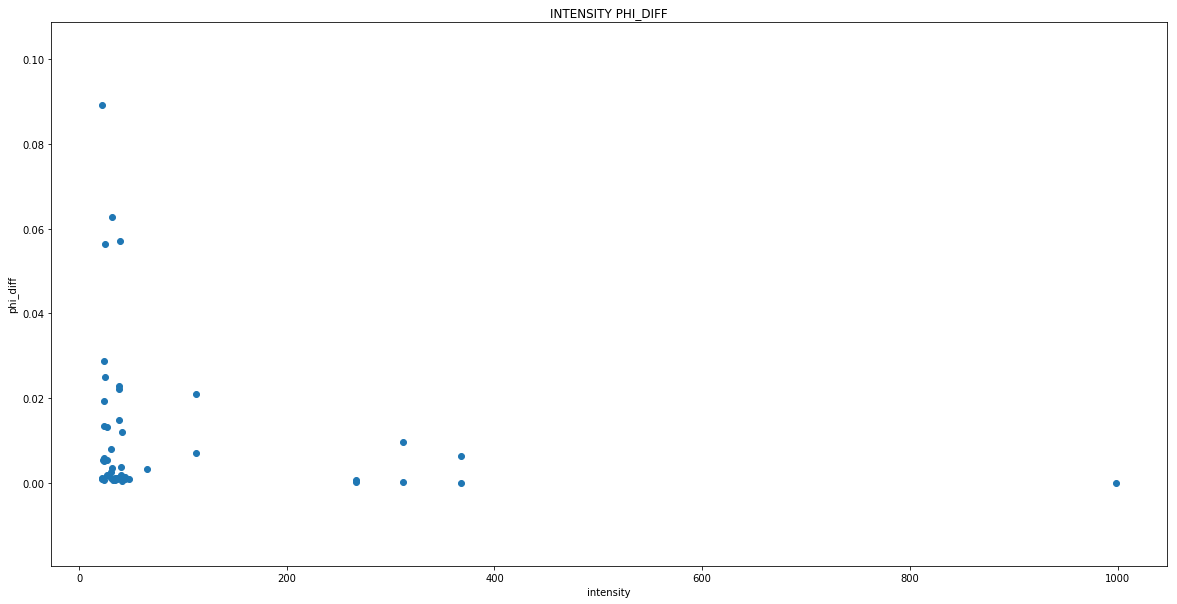

In [36]:
# Plot word intensity on x axis and phi difference on y axis on a scatterplot. 
phi_comparison_intenphi = np.copy(phi_comparison_array[:,5:])
x = phi_comparison_intenphi[:,1]
y = phi_comparison_intenphi[:,0]
fig = plt.figure()
scatterplot = fig.add_subplot(1,1,1)
plt.scatter(x,y)
fig.set_size_inches(20,10)
plt.title("INTENSITY PHI_DIFF")
plt.xlabel("intensity")
plt.ylabel("phi_diff")
plt.show()
fig.savefig(str(experiment_docs[0])+".png")

In [37]:
# CSV export of phi comparison. 
np.savetxt("compare_phi_"+str(experiment_docs[0])+".csv", phi_comparison_array, delimiter=",", fmt="%s")

# Theta differences -> PROTOTYPE02: is it due to thresholding? 

In [38]:
# Check the material and immaterial words for each topic to see if theta differences are due to thresholding. 
topics_tested = np.array(output_data_theta)[:,1]
temp =[]  
for t in topics_tested: 
    temp.append(int(t))
topics_tested = temp
print("topic", "material", "immaterial")
for topic in topics_tested: 
    topic_tested = topic
    count_material = 0
    count_immaterial = 0
    for line in phi_original: 
        if line[2] == topic_tested:
            if line[1] not in material_words_list:
                count_immaterial += 1
            else:
                count_material += 1
    print(topic_tested, count_material, count_immaterial)

('topic', 'material', 'immaterial')
(271, 39, 951)
(413, 1, 0)
(468, 1, 0)
(200, 3, 31)


In [39]:
list = []
for topic in gamma_vector_calculated: 
        if topic>0.05: 
            print topic
            print gamma_vector_calculated.tolist().index(topic)

0.08796768568338548
159
0.7020236790849217
271


In [40]:
gamma_vector_list = []
for topic in gamma_vector_calculated: 
        if topic>0.05: 
            probability = topic
            position = gamma_vector_calculated.tolist().index(topic)
            for name, pos in unique_topics.items():
                if pos == position:
                    print position
                    gamma_vector_list.append([name, probability])
gamma_vector = np.array(gamma_vector_list)
gamma_vector

159
271


array([[5.74230000e+04, 8.79676857e-02],
       [5.77120000e+04, 7.02023679e-01]])

In [41]:
gamma_vector_calculated


array([1.75880630e-104, 1.56862745e-104, 2.04819575e-104, 1.56862745e-104,
       2.08845699e-104, 2.10658272e-104, 1.37608627e-003, 2.13982185e-104,
       2.11189716e-003, 2.02543919e-104, 1.75881052e-104, 2.19751666e-104,
       2.16989820e-104, 1.84631812e-104, 1.84631811e-104, 1.56862745e-104,
       1.56862745e-104, 2.06908157e-104, 1.84631825e-104, 1.89917345e-104,
       2.37689068e-104, 2.18398058e-104, 1.75938096e-104, 2.18398058e-104,
       1.56862745e-104, 1.84631813e-104, 1.97195111e-104, 1.75881912e-104,
       1.56862745e-104, 2.33128600e-104, 2.04819575e-104, 4.73571838e-003,
       2.77364013e-003, 1.56862745e-104, 1.84631827e-104, 1.75881286e-104,
       2.02543919e-104, 2.00683406e-003, 1.93908598e-104, 1.56862745e-104,
       1.84631812e-104, 1.24372380e-003, 2.06908157e-104, 2.00029086e-104,
       1.93908598e-104, 1.56862745e-104, 2.34359472e-003, 2.31570761e-003,
       2.24717263e-104, 2.04819575e-104, 1.56862745e-104, 2.04819575e-104,
       2.02543919e-104, 5

In [42]:
output_data_theta

[[0, 271, 0.925464030966764],
 [0, 413, 0.0418494260642831],
 [0, 468, 0.0101604220097222],
 [0, 200, 0.0159164772206027]]

In [43]:
gamma_compare

array([[1.00665362e-100, 1.75880630e-104, 1.00647774e-100],
       [1.00665362e-100, 1.56862745e-104, 1.00649676e-100],
       [1.00665362e-100, 2.04819575e-104, 1.00644880e-100],
       ...,
       [1.00665362e-100, 2.52128144e-104, 1.00640149e-100],
       [1.00665362e-100, 2.81983342e-104, 1.00637164e-100],
       [1.00665362e-100, 2.74751267e-003, 2.74751267e-003]])

In [44]:
for j in phi_matrix[0]:
    for i in phi_matrix[0][j]:
        if i > 0.01:
            print j, i

2 1.0
26629 1.0
16391 0.45764680425868937
16391 0.5423531957413107
4104 0.9866977195462332
4104 0.012255266712577999
10250 0.07992181495640668
10250 0.1914118815583417
10250 0.06457312237368495
10250 0.5546014658107488
10250 0.10051200409787985
4098 1.0
8877 0.9921063758279177
12306 0.6718029011835316
12306 0.32819709881646847
22547 1.0
24 0.3276934660606324
24 0.4834312499212643
24 0.18887528401810325
6169 1.0
8221 0.4719624810877645
8221 0.5280375189122355
20513 0.26423574361652513
20513 0.735764256383475
20514 0.3647440982689796
20514 0.4105361343990432
20514 0.0724906048467823
20514 0.15222916248519477
16368 0.6308249695034339
16368 0.21020748527289543
16368 0.021507416188743113
16368 0.11663476756682703
16368 0.02082536146810041
18470 1.0
39 0.9998573320311404
2089 1.0
16430 0.015859097139622365
16430 0.04977293283169501
16430 0.10314855511664331
16430 0.7295694672576148
16430 0.10164994765442449
2099 0.5287993588497172
2099 0.47120064115028276
20532 1.0
12345 1.0
22587 0.55591751

10716 0.07924186099523066
10716 0.11758778220113604
5882 1.0
12769 1.0
27107 1.0
10724 0.8793516329196153
10724 0.12064836708038473
16869 1.0
6630 1.0
16872 0.6038664344274407
16872 0.22012354608586207
16872 0.1760100194866972
5543 0.12161390522006989
5543 0.3597605819429813
5543 0.4531287598881666
5543 0.06549675294878225
25071 0.44105575023874516
25071 0.5589442497612548
6641 0.9962940259718942
18933 1.0
27126 1.0
12713 0.018300730289354528
12713 0.12799912347805212
12713 0.020927786839686893
12713 0.8327723593929065
27129 0.02003362508939595
27129 0.977221789401804
19657 1.0
18941 0.9991980780017559
10750 0.6689832193592831
10750 0.3310167806407168
511 1.0
16897 0.6177779660556026
16897 0.1789444353264511
16897 0.15823774016606465
16897 0.045039858451881645
8619 0.11391484484411019
8619 0.8860851551558898
21000 0.24130653244372746
21000 0.08485028314236089
21000 0.12517575931188998
21000 0.5486674251020217
23051 0.9977892944715441
2572 0.0404404212383101
2572 0.9351978760647124
2100

4955 1.0
9055 0.23911793186442068
9055 0.7421778844482952
9055 0.018704183687284145
21345 0.8224159347823957
21345 0.1775840652176043
25448 0.9940425756928432
15209 1.0
21354 0.16819319506600725
21354 0.5996441547578574
21354 0.23216265017613535
17261 1.0
23407 1.0
15219 0.09372275925723265
15219 0.14835206944925314
15219 0.01849508461145126
15219 0.22001601367732307
15219 0.12930141719294083
15219 0.05744660418750129
15219 0.06161342099407671
15219 0.025599920852598344
15219 0.13454533359810675
15219 0.0430602200985691
15219 0.03903870866742113
15219 0.02336874582456623
16464 0.7897024337570221
16464 0.21029756624297796
24383 1.0
15230 1.0
7039 0.7889454839292466
7039 0.21105451607075335
10048 0.7176322625715017
10048 0.2823677374284983
4994 0.1663059316722824
4994 0.10148168925900711
4994 0.7322123790687105
9091 0.3156695942529787
9091 0.17588195917300667
9091 0.48642209354398985
9091 0.02202635303002499
13190 0.9962366388961068
23431 0.6254085516028577
23431 0.1453889828835875
23431

15418 0.6910934351135072
15418 0.3089065648864927
25843 1.0
15604 0.9179286253109418
15604 0.02691415180576371
15604 0.05515722288329446
19703 0.249481514739181
19703 0.34427451928199443
19703 0.4062439659788245
5372 0.6773810253662741
5372 0.32261897463372596
19712 0.09927729016467757
19712 0.01211487665261613
19712 0.8886078331827063
23810 1.0
11819 0.9974024791740969
13575 0.04338228461105694
13575 0.02608759196903011
13575 0.09233585592925539
13575 0.03499164218762075
13575 0.7726941084626525
13575 0.030508516840384407
26639 0.9798477328634265
20012 0.880908670211564
20012 0.03496782734063915
20012 0.08412350244779693
7435 1.0
23820 0.9938143953430097
25474 0.021878816693114735
25474 0.9186958500913547
25474 0.011621856906121185
25474 0.023611896419145247
21774 0.08153253847107975
21774 0.9184674615289201
7439 0.4181758410668785
7439 0.5818241589331216
7441 0.05066443482907952
7441 0.014800982015289866
7441 0.012107412609170408
7441 0.12595800944613045
7441 0.7872289344747656
23707

18051 0.5895885549492663
18051 0.04000665123919408
18051 0.37040479381153957
20102 0.9994151517423414
16008 1.0
18058 1.0
1303 0.9797620571856189
26256 0.6623734242887706
26256 0.3376265757112294
22162 0.05184585874175222
22162 0.09161891152481648
22162 0.24541813940106236
22162 0.611117090332369
20118 1.0
14617 0.12281122254218334
14617 0.619829004911011
14617 0.25735977254680553
22168 0.995484488085764
23492 0.16796646078317565
23492 0.3595715227173138
23492 0.4724620164995105
18074 0.18892345502377575
18074 0.2778664165275804
18074 0.3450351211205447
18074 0.03364465857921254
18074 0.15453034874888674
1693 1.0
16032 0.9494297587571071
16032 0.05057024124289295
1697 1.0
18693 1.0
13990 1.0
7848 0.03224047103083077
7848 0.03609284944945769
7848 0.03148771842525145
7848 0.05860698624506449
7848 0.8415719748493955
24948 1.0
3755 1.0
18097 0.024857743534748428
18097 0.9751422564652517
23107 0.7261008310894282
23107 0.2738991689105718
23155 0.01955936964516814
23155 0.9592375436356907
119

In [45]:
unique_topics

{57401: 405,
 57402: 139,
 57403: 140,
 57404: 141,
 57405: 142,
 57406: 143,
 57407: 144,
 57408: 145,
 57409: 146,
 57410: 147,
 57411: 148,
 57412: 149,
 57413: 150,
 57414: 151,
 57415: 152,
 57416: 153,
 57417: 154,
 57418: 155,
 57419: 156,
 57420: 157,
 57421: 406,
 57422: 158,
 57423: 159,
 57424: 160,
 57425: 161,
 57426: 162,
 57427: 163,
 57428: 164,
 57429: 165,
 57430: 166,
 57431: 167,
 57432: 168,
 57433: 169,
 57434: 170,
 57435: 171,
 57436: 172,
 57437: 173,
 57438: 174,
 57439: 175,
 57440: 176,
 57441: 177,
 57442: 178,
 57443: 179,
 57444: 407,
 57445: 180,
 57446: 181,
 57447: 182,
 57448: 183,
 57449: 184,
 57450: 408,
 57451: 6,
 57452: 7,
 57453: 8,
 57454: 9,
 57455: 10,
 57456: 11,
 57457: 12,
 57458: 13,
 57459: 14,
 57460: 15,
 57461: 16,
 57462: 409,
 57463: 17,
 57464: 18,
 57465: 19,
 57466: 20,
 57467: 21,
 57468: 22,
 57469: 55,
 57470: 23,
 57471: 24,
 57472: 25,
 57473: 26,
 57474: 27,
 57475: 28,
 57476: 29,
 57477: 30,
 57478: 31,
 57479: 0,
 57480